In [1]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [2]:
# Importing the required libraries
from pyspark import pandas as ps
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense

In [3]:
# sc master - running locally
sc.master

'local[*]'

In [4]:
import warnings
warnings.filterwarnings("ignore")

## 1. Load the dataset

In [5]:
# Loading a dataset into SparkData frame
spark = SparkSession.builder.getOrCreate()
sdf=spark.read.csv('/user1/hsa-incidents-2017-2021.csv', header=True, inferSchema=True)

In [6]:
sdf.show(10)

+----------+--------+--------------------+----------------+-------------------+----+-------+--------------------+
|       Age|Gender  |         NACE Sector|   Incident Type|Employment Status  |Year| County|             Trigger|
+----------+--------+--------------------+----------------+-------------------+----+-------+--------------------+
|0-17 Years|    Male|    F - CONSTRUCTION|Non-fatal injury|           Employee|2017| Carlow|   Lifting, carrying|
|0-17 Years|  Female|   C - MANUFACTURING|Non-fatal injury|           Employee|2017| Dublin|Other triggers no...|
|0-17 Years|  Female|Q - HUMAN HEALTH ...|Non-fatal injury|           Employee|2017| Dublin|Fall on same leve...|
|0-17 Years|    Male|   C - MANUFACTURING|Non-fatal injury|           Employee|2017| Offaly|    Pushing, pulling|
|0-17 Years|    Male|I - ACCOMMODATION...|Non-fatal injury|           Employee|2017| Dublin|Loss of control o...|
|0-17 Years|  Female|I - ACCOMMODATION...|Non-fatal injury|           Employee|2017|  Sl

In [7]:
# The inferred schema can be visualized using the printSchema() method
sdf.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Gender  : string (nullable = true)
 |-- NACE Sector: string (nullable = true)
 |-- Incident Type: string (nullable = true)
 |-- Employment Status  : string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Trigger: string (nullable = true)



The first view of spark Dataframe.

## 2. Prepare and understand data for the modelling

In [8]:
# Checking datatypes
sdf.dtypes

[('Age', 'string'),
 ('Gender  ', 'string'),
 ('NACE Sector', 'string'),
 ('Incident Type', 'string'),
 ('Employment Status  ', 'string'),
 ('Year', 'int'),
 ('County', 'string'),
 ('Trigger', 'string')]

In [9]:
# Checking a shape of pyspark Dataframe
print((sdf.count(), len(sdf.columns)))

(45787, 8)


### 2.1. Handle duplicates

In [10]:
# Check for duplicates
print('Count of rows: {0}'.format(sdf.count()))
print('Count of distinct rows: {0}'.format(sdf.distinct().count()))

Count of rows: 45787
Count of distinct rows: 26504


In [11]:
# Dropping these duplicated rows by using .dropDuplicates(...) method.
sdf1=sdf.dropDuplicates()

In [12]:
#Confirmation
print('Count of rows: {0}'.format(sdf1.count()))
print('Count of distinct rows: {0}'.format(sdf1.distinct().count()))

Count of rows: 26504
Count of distinct rows: 26504


### 2.2. Missing observations

In [13]:
# Checking a missing observations
from pyspark.sql.functions import col,sum
sdf.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in sdf.columns)).show()

+---+--------+-----------+-------------+-------------------+----+------+-------+
|Age|Gender  |NACE Sector|Incident Type|Employment Status  |Year|County|Trigger|
+---+--------+-----------+-------------+-------------------+----+------+-------+
|  0|       0|          0|            0|                  0|   0|    15|      0|
+---+--------+-----------+-------------+-------------------+----+------+-------+



In [14]:
# To drop any rows that have missing data.
sdf2= sdf1.dropna()

In [15]:
# Checking a missing observations
from pyspark.sql.functions import col,sum
sdf2.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in sdf1.columns)).show()

+---+--------+-----------+-------------+-------------------+----+------+-------+
|Age|Gender  |NACE Sector|Incident Type|Employment Status  |Year|County|Trigger|
+---+--------+-----------+-------------+-------------------+----+------+-------+
|  0|       0|          0|            0|                  0|   0|     0|      0|
+---+--------+-----------+-------------+-------------------+----+------+-------+



In [16]:
# Confirmation of final data shape of dataset
print((sdf2.count(), len(sdf2.columns)))

(26489, 8)


## 2.3. Descriptive statistics

In [17]:
sdf2.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Gender  : string (nullable = true)
 |-- NACE Sector: string (nullable = true)
 |-- Incident Type: string (nullable = true)
 |-- Employment Status  : string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Trigger: string (nullable = true)



The Dataframe was not suitable for a basis descriptive statistics because of indexes were all a string type. So, here I am replacing index of string to integer.

In [18]:
# Replacing index string to integer for calculate the basic descriptive statistics
sdf3= sdf2.na.replace(['0-17 Years', '18-24 years','25-34 years', '35-44 years', 
             '45-54 years','55-64 years', '65-99 years','Age unknown'], ['0','1','2','3','4','5','6','7'], 'Age') 
sdf4=sdf3.na.replace(['Non-fatal injury','Fatality','Non-work related','Dangerous Occurrence'],['0','1','0','1'], 'Incident Type') 
sdf5=sdf4.na.replace(['Employee','Family worker', 'Non-worker', 'Trainee', 'Employment status unknown','Self-employed'],['0','1','2','3','4','5'], 'Employment Status  ')
sdf6=sdf5.na.replace(['F - CONSTRUCTION','C - MANUFACTURING','Q - HUMAN HEALTH AND SOCIAL WORK ACTIVITIES', 'I - ACCOMMODATION AND FOOD SERVICE ACTIVITIES', 'P - EDUCATION', 'G - WHOLESALE AND RETAIL TRADE;REPAIR OF MOTOR VEHICLES AND MOTORCYCLES', 'A - AGRICULTURE, FORESTRY AND FISHING','S - OTHER SERVICE ACTIVITIES','N - ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES','H - TRANSPORTATION AND STORAGE',
                     'O - PUBLIC ADMINISTRATION AND DEFENCE;COMPULSORY SOCIAL SECURITY', 'K - FINANCIAL AND INSURANCE ACTIVITIES', 'R - ARTS, ENTERTAINMENT AND RECREATION',  'J - INFORMATION AND COMMUNICATION', 'M - PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES','E - WATER SUPPLY;SEWERAGE,WASTE MANAGEMENT AND REMEDIATION ACTIVITIES', 'B - MINING AND QUARRYING','L - REAL ESTATE ACTIVITIES', 
                     'D - ELECTRICITY,GAS,STEAM AND AIR CONDITIONING SUPPLY', 'U - ACTIVITIES OF EXTRA TERRITORIAL ORGANISATIONS AND BODIES'], ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19'], 'NACE Sector')
sdf7=sdf6.na.replace(['Lifting, carrying','Other triggers not listed','Fall on same level (slip, stumble etc)','Pushing, pulling', 'Loss of control of machine','Loss of control of object being worked on','Fall from height', 'Loss of control of hand held tool',
                     'Accident trigger unknown','Bending down','Loss of control of means of transport or handling equipment','Overflow, leakage, emission of liquid','Loss of control of animal','Attack by animal','Twisting, turning', 'Body movement (no physical stress)','Breakage of material at joints', 'Violence, aggression, threat by member of public','Fall, collapse of material - on same level','Other loss of control trigger',
                     'Other body movement trigger','Uncoordinated or untimely movements', 'Fall, collapse of material - from above','Shock, fright','Person in inappropriate area',
                     'Other fall-related accident trigger','Overflow, leakage, emission of gas','Other shock, fright, violence trigger','Overflow, leakage, emission of smoke/dust','Other body movement','Electrical problem - indirect contact','Overflow, leakage, emission of solid material','Other breakage/collapse related trigger','Explosion','Fire, flare up','Twisting leg or ankle','Violence, aggression, threat by co-worker',
                     'Electrical problem - direct contact','Other overflow, leakage, emission trigger','Breakage causing splinters (e.g. glass, stone, metal)','Fall, collapse of material - from below','Kneeling on, sitting on, leaning against','Carried along by something','Walk on sharp object'],
                     ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43'], 'Trigger')
                       

newsdf=sdf7.na.replace(['Male','Female','Gender unknown'], ['0','1', '2'], 'Gender  ')


In [19]:
newsdf.show(10)

+---+--------+-----------+-------------+-------------------+----+---------+-------+
|Age|Gender  |NACE Sector|Incident Type|Employment Status  |Year|   County|Trigger|
+---+--------+-----------+-------------+-------------------+----+---------+-------+
|  0|       0|          9|            0|                  2|2018|   Dublin|      3|
|  0|       0|          4|            0|                  2|2018| Monaghan|      2|
|  1|       0|          9|            0|                  0|2017|Westmeath|      3|
|  1|       1|          5|            0|                  0|2017|  Kildare|      2|
|  1|       1|          2|            0|                  0|2018| Limerick|     23|
|  1|       1|          5|            0|                  0|2018| Kilkenny|      5|
|  1|       1|          3|            0|                  0|2018|   Offaly|      3|
|  1|       0|          1|            0|                  0|2019| Longford|      0|
|  1|       0|         10|            0|                  0|2019|   Dublin| 

### Data Dictionary
Age: ['0-17 Years'=0,
  '18-24 years'=1,
  '25-34 years'=2,
  '35-44 years'=3,
  '45-54 years'=4,
  '55-64 years'=5,
  '65-99 years'=6,
  'Age unknown'=7]

Gender: ['Male'=0, 'Female'=1, 'Gender unknown'=2]

Incident Type': ['Non-fatal injury'=0,
  'Fatality'=1,
  'Non-work related'=2,
  'Dangerous Occurrence'=3],
  
Employment Status  ': ['Employee'=0,
  'Family worker'=1,
  'Non-worker'=2,
  'Trainee'=3,
  'Employment status unknown'=4,
  'Self-employed'=5] 

NACE Sector': ['F - CONSTRUCTION'=0,
  'C - MANUFACTURING'=1,
  'Q - HUMAN HEALTH AND SOCIAL WORK ACTIVITIES=2,
  'I - ACCOMMODATION AND FOOD SERVICE ACTIVITIES'=3,
  'P - EDUCATION'=4,
  'G - WHOLESALE AND RETAIL TRADE;REPAIR OF MOTOR VEHICLES AND MOTORCYCLES'=5,
  'A - AGRICULTURE, FORESTRY AND FISHING'=6,
  'S - OTHER SERVICE ACTIVITIES'=7,
  'N - ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES'=8,
  'H - TRANSPORTATION AND STORAGE'=9,
  'O - PUBLIC ADMINISTRATION AND DEFENCE;COMPULSORY SOCIAL SECURITY'=10,
  'K - FINANCIAL AND INSURANCE ACTIVITIES'=11,
  'R - ARTS, ENTERTAINMENT AND RECREATION'=12,
  'J - INFORMATION AND COMMUNICATION'=13,
  'M - PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES'=14,
  'E - WATER SUPPLY;SEWERAGE,WASTE MANAGEMENT AND REMEDIATION ACTIVITIES'=15,
  'B - MINING AND QUARRYING'=16,
  'L - REAL ESTATE ACTIVITIES'=17,
  'D - ELECTRICITY,GAS,STEAM AND AIR CONDITIONING SUPPLY'=18,
  'U - ACTIVITIES OF EXTRA TERRITORIAL ORGANISATIONS AND BODIES=19'

'Trigger':'Lifting, carrying'=0,'Other triggers not listed'=1,'Fall on same level (slip, stumble etc)':2,'Pushing, pulling'=3, 'Loss of control of machine'=4,'Loss of control of object being worked on'=5,'Fall from height'=6, 'Loss of control of hand held tool'=7, 'Accident trigger unknown'=8,'Bending down'=9,'Loss of control of means of transport or handling equipment'=10,'Overflow, leakage, emission of liquid'=11,'Loss of control of animal'=12,'Attack by animal'=13,'Twisting, turning'=14, 'Body movement (no physical stress)'=15,'Breakage of material at joints'=16, 'Violence, aggression, threat by member of public'=17,'Fall, collapse of material - on same level'=18,'Other loss of control trigger'=19,'Other body movement trigger'=20,'Uncoordinated or untimely movements'=21, 'Fall, collapse of material - from above'=22,'Shock, fright'=23,'Person in inappropriate area'=24,'Other fall-related accident trigger'=25,'Overflow, leakage, emission of gas'=26,'Other shock, fright, violence trigger'=27,'Overflow, leakage, emission of smoke/dust'=28,'Other body movement'=29,'Electrical problem - indirect contact'=30,'Overflow, leakage, emission of solid material'=31,'Other breakage/collapse related trigger'=32,'Explosion'=33,'Fire, flare up'=34,'Twisting leg or ankle'=35,'Violence, aggression, threat by co-worker'=36,
           'Electrical problem - direct contact'=37,'Other overflow, leakage, emission trigger'=38,'Breakage causing splinters (e.g. glass, stone, metal)'=39,'Fall, collapse of material - from below'=40,'Kneeling on, sitting on, leaning against'=41,'Carried along by something'=42,'Walk on sharp object'=43

In [20]:
newsdf.printSchema()

root
 |-- Age: string (nullable = true)
 |-- Gender  : string (nullable = true)
 |-- NACE Sector: string (nullable = true)
 |-- Incident Type: string (nullable = true)
 |-- Employment Status  : string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Trigger: string (nullable = true)



In [21]:
# Converting String to Integer type
n1=newsdf.withColumn("Age",col("Age").cast('int'))
n2=n1.withColumn("Gender  ",col("Gender  ").cast('int'))
n3=n2.withColumn("NACE Sector",col("NACE Sector").cast('int'))
n4=n3.withColumn('Incident Type',col('Incident Type').cast('int'))
n5=n4.withColumn("Employment Status  ",col('Employment Status  ').cast('int'))
n6=n5.withColumn("Trigger",col('Trigger').cast('int'))

In [22]:
# Final view of dataframe
n6.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Gender  : integer (nullable = true)
 |-- NACE Sector: integer (nullable = true)
 |-- Incident Type: integer (nullable = true)
 |-- Employment Status  : integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- County: string (nullable = true)
 |-- Trigger: integer (nullable = true)



In [23]:
# For categorical columns, checking frequencies of values using .groupby(...) method.
n6.groupby('Gender  ').count().show()
n6.groupby('Age').count().show()
n6.groupby('County').count().show()
n6.groupby('Year').count().show()
n6.groupby('Incident Type').count().show()

+--------+-----+
|Gender  |count|
+--------+-----+
|       1| 8886|
|       2| 1223|
|       0|16380|
+--------+-----+

+---+-----+
|Age|count|
+---+-----+
|  1| 2979|
|  6|  654|
|  3| 6353|
|  5| 3601|
|  4| 5567|
|  7| 1425|
|  2| 5533|
|  0|  377|
+---+-----+

+---------+-----+
|   County|count|
+---------+-----+
|    Clare|  658|
|  Wexford|  903|
|  Leitrim|  169|
|Roscommon|  325|
|   Dublin| 5858|
| Limerick| 1381|
|  Donegal|  672|
|   Galway| 1255|
|   Offaly|  630|
|     Cork| 2792|
|  Kildare| 1558|
|Tipperary| 1047|
| Monaghan|  503|
|  Wicklow|  750|
|     Mayo|  801|
|    Meath| 1050|
|   Carlow|  366|
|Westmeath|  744|
|    Louth|  831|
|    Sligo|  423|
+---------+-----+
only showing top 20 rows

+----+-----+
|Year|count|
+----+-----+
|2018| 5617|
|2019| 5545|
|2020| 4715|
|2017| 5571|
|2021| 5041|
+----+-----+

+-------------+-----+
|Incident Type|count|
+-------------+-----+
|            1| 1217|
|            0|25272|
+-------------+-----+



In [24]:
#define function to swap columns
def swap_columns(n6, col1, col2):
    col_list = list(n6.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    n6 = n6[col_list]
    return n6

In [25]:
#swap Incident type and Trigger columns
n6 = swap_columns(n6, 'Incident Type', 'Trigger')

In [26]:
#Drop the irrevelant columns
psdf= n6.drop("County") 

In [27]:
# Final view of dataframe
psdf.show(5)

+---+--------+-----------+-------+-------------------+----+-------------+
|Age|Gender  |NACE Sector|Trigger|Employment Status  |Year|Incident Type|
+---+--------+-----------+-------+-------------------+----+-------------+
|  0|       0|          9|      3|                  2|2018|            0|
|  0|       0|          4|      2|                  2|2018|            0|
|  1|       0|          9|      3|                  0|2017|            0|
|  1|       1|          5|      2|                  0|2017|            0|
|  1|       1|          2|     23|                  0|2018|            0|
+---+--------+-----------+-------+-------------------+----+-------------+
only showing top 5 rows



## 4. Artificial Neural network 

In [28]:
#Converting to numpay (array)
npsdf=psdf.select('Age', 'Gender  ', 'NACE Sector', 'Trigger', 'Employment Status  ', 'Year', 'Incident Type').toPandas().to_numpy()

In [29]:
from sklearn.model_selection import train_test_split
#split into input (X) and output (y) variables
X=npsdf[:, 0:6]
y=npsdf[:,6]
# Split into Training and Testing parts
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.10)

#display X, y
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23840, 6), (2649, 6), (23840,), (2649,))

In [30]:
#define the keras model
model= Sequential()
model.add(Dense(12, input_dim=6, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                84        
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [31]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
745/745 [==============================] - 1s 907us/step - loss: 1.8434 - accuracy: 0.9526
Epoch 2/100
745/745 [==============================] - 1s 1ms/step - loss: 0.1303 - accuracy: 0.9587
Epoch 3/100
745/745 [==============================] - 1s 1ms/step - loss: 0.1150 - accuracy: 0.9649
Epoch 4/100
745/745 [==============================] - 1s 1ms/step - loss: 0.0972 - accuracy: 0.9685
Epoch 5/100
745/745 [==============================] - 1s 813us/step - loss: 0.0878 - accuracy: 0.9715
Epoch 6/100
745/745 [==============================] - 1s 789us/step - loss: 0.0789 - accuracy: 0.9762
Epoch 7/100
745/745 [==============================] - 1s 784us/step - loss: 0.0828 - accuracy: 0.9764
Epoch 8/100
745/745 [==============================] - 1s 758us/step - loss: 0.0752 - accuracy: 0.9775
Epoch 9/100
745/745 [==============================] - 1s 939us/step - loss: 0.0800 - accuracy: 0.9780
Epoch 10/100
745/745 [==============================] - 1s 954us/step - loss: 0

In [33]:
# Save the model
model.save("incident.h5")

In [34]:
# load the model
from keras.models import load_model 
loaded_model=load_model("incident.h5")

In [35]:
# evaluate the keras model
_, accuracy=model.evaluate(X_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))

83/83 [==============================] - 0s 3ms/step - loss: 0.0474 - accuracy: 0.9883
Accuracy: 98.83


In [36]:
# make probability predictions with the model
predictions= model.predict(X_test)

83/83 [==============================] - 0s 850us/step


In [37]:
#round predictions
rounded= [round(x[0]) for x in predictions]

In [38]:
for i in range(10):
    print('%s=>%d (expected: %d)' % (X[i].tolist(), predictions[i], y[i]))

[0, 0, 9, 3, 2, 2018]=>0 (expected: 0)
[0, 0, 4, 2, 2, 2018]=>0 (expected: 0)
[1, 0, 9, 3, 0, 2017]=>0 (expected: 0)
[1, 1, 5, 2, 0, 2017]=>0 (expected: 0)
[1, 1, 2, 23, 0, 2018]=>0 (expected: 0)
[1, 1, 5, 5, 0, 2018]=>0 (expected: 0)
[1, 1, 3, 3, 0, 2018]=>0 (expected: 0)
[1, 0, 1, 0, 0, 2019]=>0 (expected: 0)
[1, 0, 10, 23, 0, 2019]=>0 (expected: 0)
[1, 0, 10, 2, 0, 2019]=>0 (expected: 0)


In [39]:
df=psdf.select('Age', 'Gender  ', 'NACE Sector', 'Trigger', 'Employment Status  ', 'Year', 'Incident Type').toPandas()
s=df['Age']
s=s[:2649]
s.shape

(2649,)

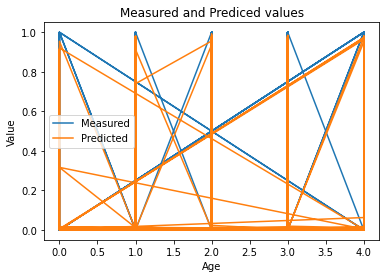

In [40]:
import matplotlib as plt
import matplotlib.pyplot as plt
plt.plot(s, y_test, label="Measured")
plt.plot(s, predictions, label='Predicted')
plt.legend()
plt.xlabel("Age")
plt.ylabel("Value")
plt.title("Measured and Prediced values")
plt.show()